In [1]:
from math import sqrt
from datetime import datetime
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import LSTM, Bidirectional, GRU
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# Datayı Yükleyelim
path = r'c:\sxk9gd_6ay.xlsx'
data = pd.read_excel(path, date_format=[0])
# İlk 5 Satır
data.head()

,DATE_TIME,MAXIMUM_SPEED,MINIMUM_SPEED,AVERAGE_SPEED,NUMBER_OF_VEHICLES
0,2022-01-01 00:00:00,155,4,76,168
1,2022-01-01 01:00:00,153,2,77,188
2,2022-01-01 02:00:00,156,3,82,150
3,2022-01-01 03:00:00,146,2,60,101
4,2022-01-01 04:00:00,142,21,82,74


In [3]:
#Datetime Haline Getirilmesi
data['DATE_TIME'] = pd.to_datetime(data.DATE_TIME, format='%Y-%m-%d %H:%M')
#İndex'e Alınması
data.index = data.DATE_TIME

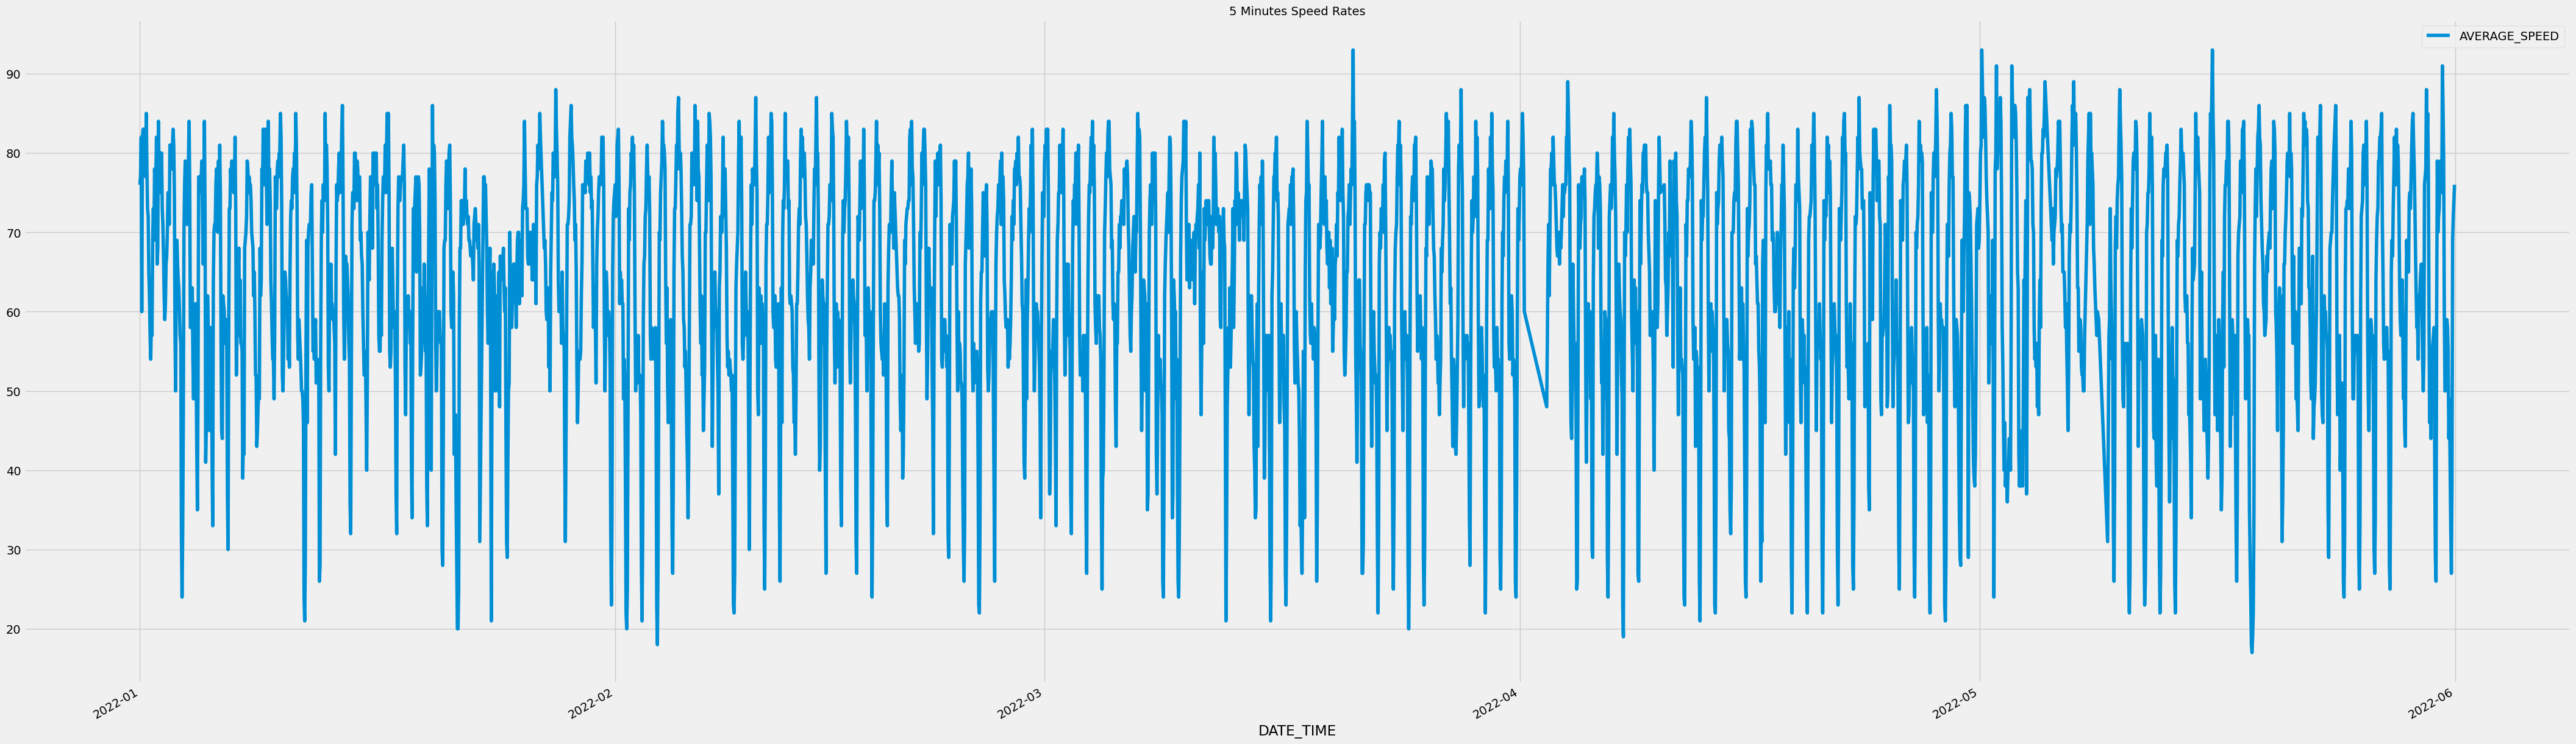

In [4]:
fig = plt.figure(figsize=(48,16))
data.AVERAGE_SPEED.plot(label='AVERAGE_SPEED')
plt.legend(loc='best')
plt.title('5 Minutes Speed Rates', fontsize=14)
plt.show()

In [5]:
values = data['AVERAGE_SPEED'].values.reshape(-1,1)
values = values.astype('float32')

In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(values)

In [7]:
# %60 Train % 40 Test
TRAIN_SIZE = 0.60
train_size = int(len(dataset) * TRAIN_SIZE)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print("Veri Seti Sayıları (training set, test set): " + str((len(train), len(test))))
#dataset[train_size:len(dataset)]

Veri Seti Sayıları (training set, test set): (2122, 1415)


In [8]:
def create_dataset(dataset, window_size):
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        a = dataset[i:(i + window_size), 0]
        data_X.append(a)
        data_Y.append(dataset[(i + window_size), 0])
    return(np.array(data_X), np.array(data_Y))

In [9]:
# Verisetlerimizi Oluşturalım
window_size = 6
train_X, train_Y = create_dataset(train, window_size)
test_X, test_Y = create_dataset(test, window_size)
print("Original training data shape:")
print(train_X.shape)

Original training data shape:
(2115, 6)


In [10]:
class RBFNetwork:
    def __init__(self, num_centers, sigma):
        self.num_centers = num_centers
        self.sigma = sigma
        self.centers = None
        self.weights = None

    def _calculate_activations(self, X):
        num_samples = X.shape[0]
        num_features = X.shape[1]
        activations = np.zeros((num_samples, self.num_centers))

        for i in range(num_samples):
            for j in range(self.num_centers):
                distance = np.linalg.norm(X[i] - self.centers[j])
                activations[i][j] = np.exp(-distance**2 / (2 * self.sigma**2))

        return activations

    def fit(self, X, y):
        self.centers = X[np.random.choice(X.shape[0], self.num_centers, replace=False)]
        activations = self._calculate_activations(X)

        self.weights = np.linalg.pinv(activations.T @ activations) @ activations.T @ y

    def predict(self, X):
        activations = self._calculate_activations(X)
        return activations @ self.weights

In [11]:
num_centers = 4
sigma = 10.2

rbf_net = RBFNetwork(num_centers, sigma)
rbf_net.fit(train_X, train_Y)
#predictions = rbf_net.predict(test_X)

In [12]:
y_test = test_Y.reshape(-1,1)
x_test = test_X
y_train = train_Y.reshape(-1,1)
x_train = train_X

In [13]:
y_train_pred = rbf_net.predict(x_train).reshape(-1,1)
y_test_pred = rbf_net.predict(x_test).reshape(-1,1)
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

In [14]:
score_tr = math.sqrt(mean_squared_error(y_train, y_train_pred))
print("Train data score: %.2f RMSE" % score_tr)

score_t = math.sqrt(mean_squared_error(y_test, y_test_pred))
print("Test data score: %.2f RMSE" % score_t)

Train data score: 8.39 RMSE
Test data score: 9.48 RMSE


In [15]:
from sklearn.metrics import mean_absolute_percentage_error

error_mape_tr = 100*mean_absolute_percentage_error(y_train, y_train_pred)
print("Train data score: %.2f MAPE" % error_mape_tr)

error_mape_t = 100*mean_absolute_percentage_error(y_test, y_test_pred)
print("Test data score: %.2f MAPE" % error_mape_t)


Train data score: 11.90 MAPE
Test data score: 13.72 MAPE


In [16]:
mdape_tr = np.median((np.abs(np.subtract(y_train, y_train_pred)/ y_train))) * 100
print("Train data score: %.2f MdAPE" % mdape_tr)

mdape_t = np.median((np.abs(np.subtract(y_test, y_test_pred)/ y_test))) * 100
print("Test data score: %.2f MdAPE" % mdape_t)

Train data score: 7.16 MdAPE
Test data score: 8.18 MdAPE


In [17]:
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

error_smape_tr = smape(y_train,y_train_pred)
print("Train data score: %.2f SMAPE" % error_smape_tr)

error_smape_t = smape(y_test,y_test_pred)
print("Test data score: %.2f SMAPE" % np.mean(error_smape_t))

Train data score: 11.15 SMAPE
Test data score: 12.78 SMAPE


In [18]:
from sklearn.metrics import mean_absolute_error
e_tr = y_train - y_train_pred
scale = mean_absolute_error(y_train[1:], y_train[:-1])
mase_tr = np.mean(np.abs(e_tr / scale))
print("Train data score: %.2f MASE" % mase_tr)

e_t = y_test - y_test_pred
scale = mean_absolute_error(y_test[1:], y_test[:-1])
mase_t = np.mean(np.abs(e_t / scale))
print("Test data score: %.2f MASE" % mase_t)

Train data score: 1.04 MASE
Test data score: 1.08 MASE


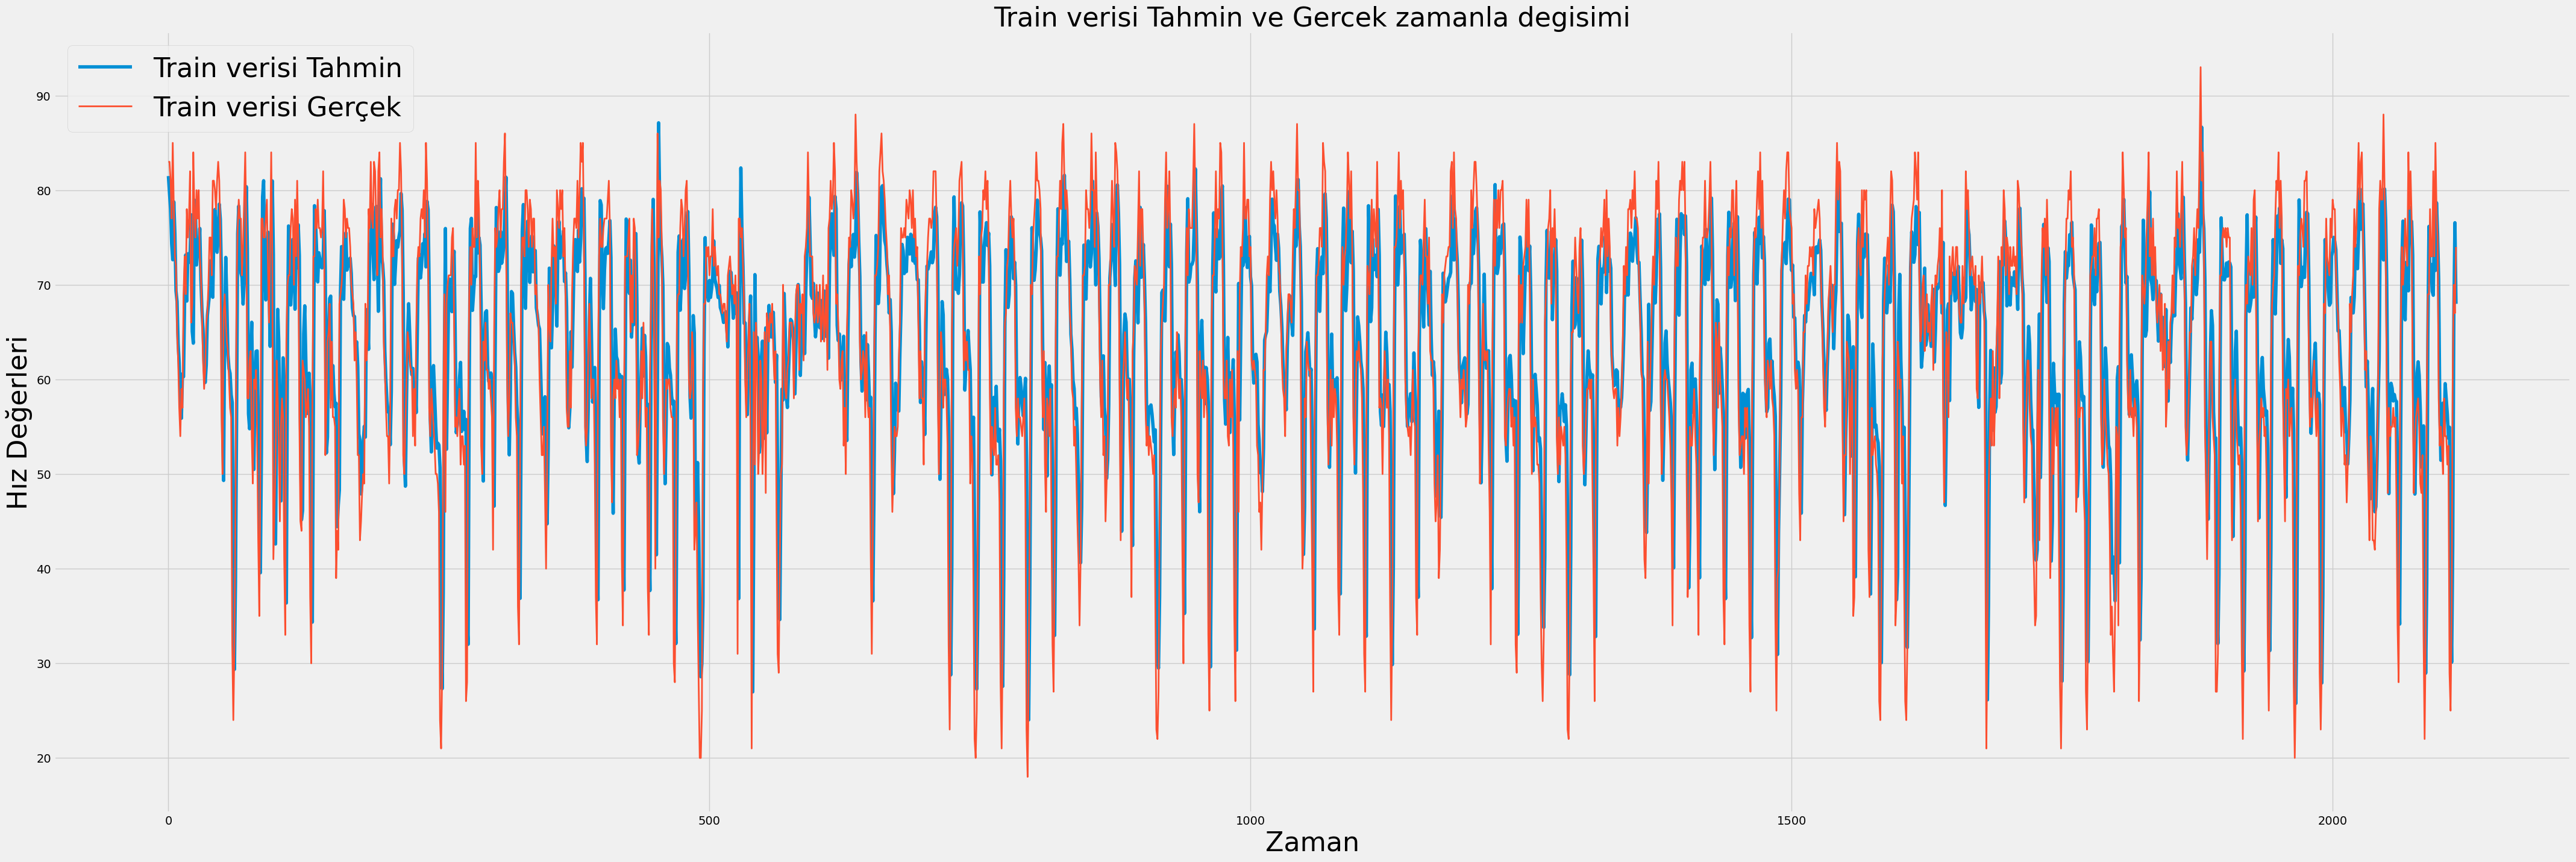

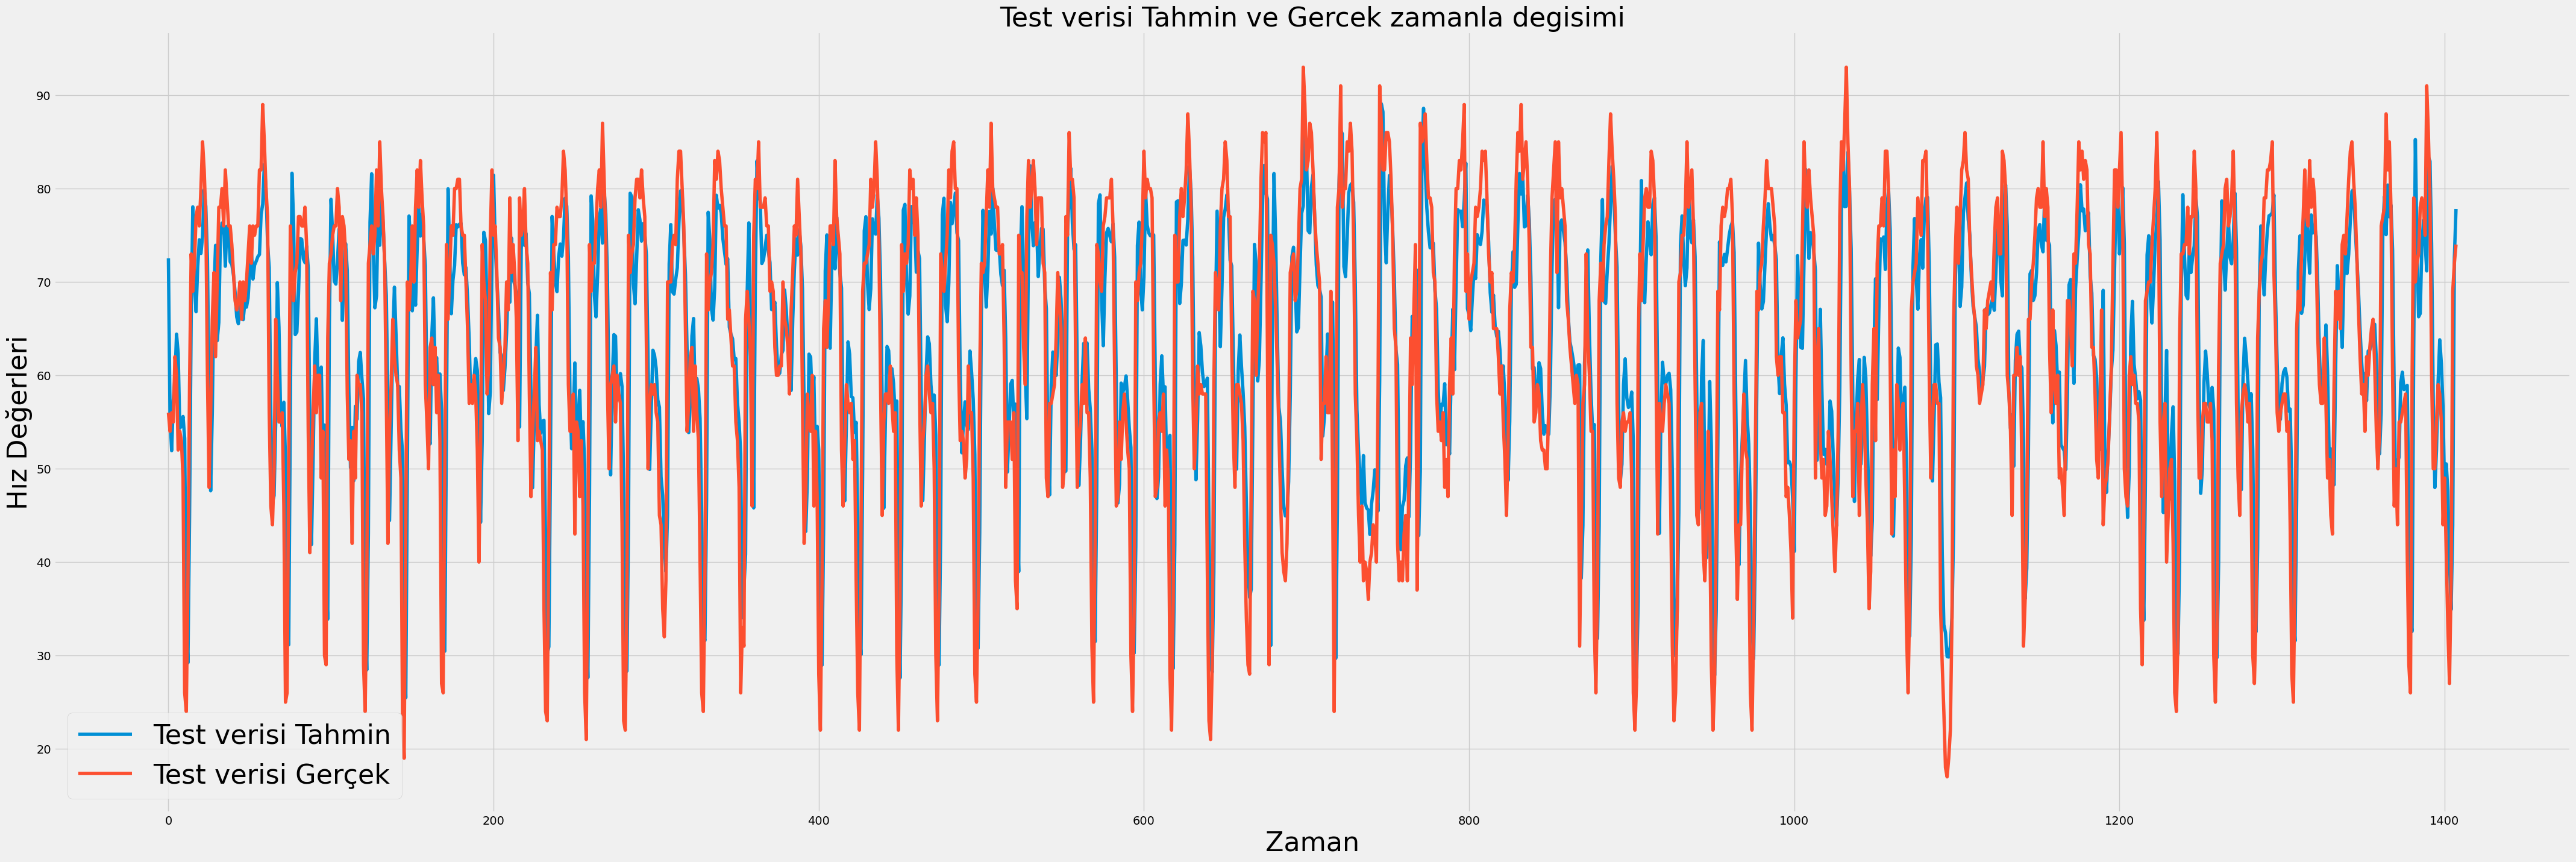

In [19]:
plt.figure(figsize=(48, 16))
plt.plot(y_train_pred, label = "Train verisi Tahmin")
plt.plot(y_train, label = "Train verisi Gerçek" , linewidth=2.0)
plt.title('Train verisi Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
plt.show()

plt.figure(figsize=(48, 16))
plt.plot(y_test_pred, label = "Test verisi Tahmin")
plt.plot(y_test, label = "Test verisi Gerçek")
plt.title('Test verisi Tahmin ve Gercek zamanla degisimi', fontsize=32)
plt.xlabel('Zaman', fontsize=32)
plt.ylabel('Hız Değerleri', fontsize=32)
plt.legend(fontsize=32)
plt.show()